## Modeling for predicting critical outcome at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.append('/content/drive/My Drive/ISSS623_2024-main/Group_Project/Self_Learning-MIMIC/')
path = '/content/drive/My Drive/ISSS623_2024-main/Group_Project/Self_Learning-MIMIC/'

In [5]:
import os
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from helpers_for_tasks import PlotROCCurve

df_train = pd.read_csv((os.path.join(path, 'train2.csv')))
df_test = pd.read_csv((os.path.join(path, 'test2.csv')))
confidence_interval = 95
random_seed = 0

In [6]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

df_train.head()

,index,subject_id,hadm_id,stay_id,intime_ed,outtime_ed,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,race,edregtime,edouttime,insurance,in_year,age,before_ed_mortality,outcome_hospitalization,outcome_inhospital_mortality,ed_death,ed_los,intime_icu,outtime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,273532,18971123,21753872.0,37200982,2149-07-15 22:41:00,2149-07-16 06:27:00,45.0,F,2149.0,NaN,2149-07-16 04:10:00,2149-07-28 18:37:00,NaN,WHITE,2149-07-15 22:41:00,2149-07-16 06:27:00,Other,2149,45.0,False,True,False,False,0 days 07:46:00,NaN,NaN,NaN,False,False,0,1,1,2149-08-01 14:27:00,16 days 08:00:00,False,0,0,0,0,0,0,7.77,NaN,16.33,37.444444,102.0,19.0,100.0,133.0,88.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.333333,72.0,16.0,100.0,165.0,105.0,0.0,3.0,1.0,103.000000,0,0,2,1,1,2
1,253777,15439233,NaN,31867345,2159-12-20 19:43:00,2159-12-20 19:59:00,18.0,M,2159.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2159,18.0,False,False,False,False,0 days 00:16:00,NaN,NaN,NaN,False,False,0,0,0,2160-02-11 01:14:00,52 days 05:15:00,False,0,0,0,0,0,0,0.27,NaN,52.22,37.111111,70.0,20.0,99.0,151.0,64.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.666667,60.0,16.0,100.0,132.0,70.0,7.0,1.0,0.0,93.000000,0,0,0,0,0,1
2,365291,15341533,NaN,30037900,2171-09-02 21:24:00,2171-09-02 21:27:00,40.0,F,2171.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2171,40.0,False,False,False,False,0 days 00:03:00,NaN,NaN,NaN,False,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,0.05,NaN,NaN,37.555556,97.0,16.0,97.0,120.0,70.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.555556,95.0,18.0,98.0,113.0,67.0,0.0,0.0,0.0,86.666667,0,0,0,1,1,1
3,76261,13512582,NaN,38777853,2131-11-08 22:59:00,2131-11-08 23:04:00,70.0,F,2131.0,NaN,NaN,NaN,NaN,HISPANIC/LATINO - PUERTO RICAN,NaN,NaN,NaN,2131,70.0,False,False,False,False,0 days 00:05:00,NaN,NaN,NaN,False,False,0,0,0,2137-11-14 18:47:00,2197 days 19:43:00,False,0,0,0,0,0,0,0.08,NaN,2197.82,37.000000,58.0,16.0,100.0,155.0,44.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.111111,51.0,18.0,96.0,173.0,63.0,2.0,3.0,2.0,81.000000,3,13,7,0,0,1
4,99718,17758321,NaN,35942414,2115-06-25 13:15:00,2115-06-25 13:38:00,50.0,M,2115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2115,50.0,False,False,False,False,0 days 00:23:00,NaN,NaN,NaN,False,False,1,1,1,NaN,NaN,False,0,0,0,0,0,0,0.38,NaN,NaN,36.555556,72.0,16.0,96.0,187.0,108.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.777778,62.0,16.0,100.0,161.0,99.0,0.0,1.0,2.0,134.333333,1,0,5,0,0,1


### 1. task-specific filter

In [7]:
df_train = df_train[df_train['ed_death'] == False]
df_test = df_test[df_test['ed_death'] == False].reset_index()

### 2. Variable Selection

In [8]:
variable = ["age", "gender",

            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d",
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d",

            "triage_temperature", "triage_heartrate", "triage_resprate",
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",

            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough",
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",

            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia",
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1",
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2",
            "cci_Cancer2", "cci_HIV",

            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy",
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_critical"

In [9]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [10]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,float64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [11]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [12]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.06275673965130121 : 1


### 3.  Modeling script

In [13]:
# Containers for all results
result_list = []

Logistic Regression:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 7.928516626358032 seconds
AUC: 0.8830856911862399
AUPRC: 0.4384987551919765
Sensitivity: 0.8074896499811818
Specificity: 0.7945511389012953
Score thresold: 0.0624486232837693
2.5 97.5


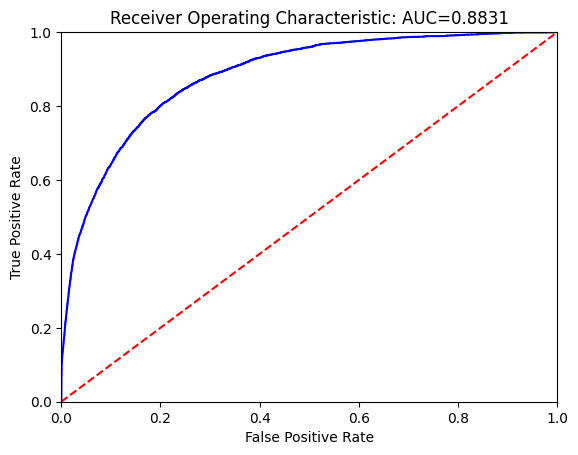

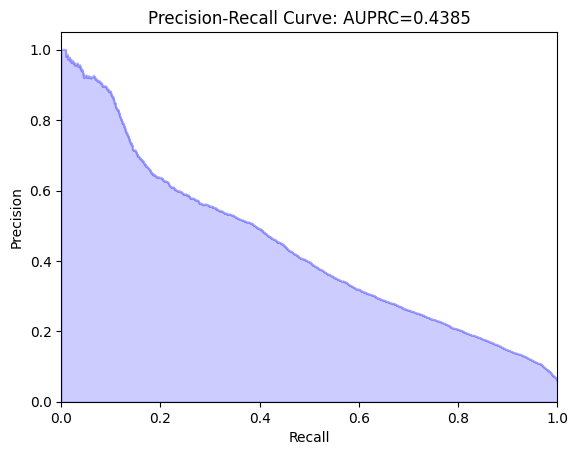

In [14]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1], y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)

RandomForest:
Training time: 84.80850505828857 seconds
AUC: 0.8927292494646327
AUPRC: 0.5191172374705223
Sensitivity: 0.7995859992472714
Specificity: 0.8250908344700216
Score thresold: 0.08
2.5 97.5


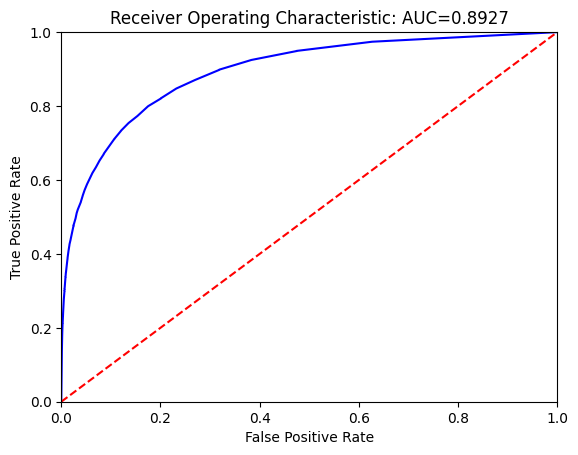

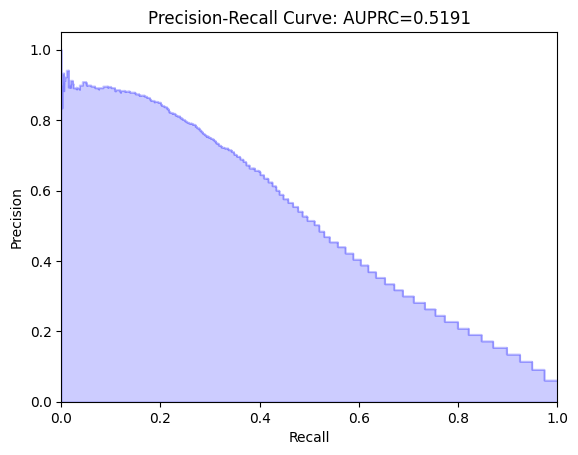

[0.09334362 0.0136141  0.00476209 0.00751626 0.01494395 0.00477482
 0.00770236 0.01339191 0.01368722 0.03203871 0.09400319 0.06990634
 0.08473737 0.04893118 0.04577221 0.08964639 0.07698255 0.03678368
 0.07992709 0.00549688 0.00551261 0.00362309 0.00136268 0.00213443
 0.00232677 0.00301105 0.0041475  0.0031638  0.00282697 0.00421124
 0.00462498 0.00404264 0.00401451 0.00225631 0.00603509 0.00222428
 0.00216016 0.00384333 0.00620671 0.00399618 0.00178703 0.00415337
 0.00426448 0.00227954 0.00318422 0.00091882 0.00590818 0.00382137
 0.00348467 0.00405106 0.00775623 0.00464069 0.00455419 0.00137089
 0.00417931 0.00460435 0.00351209 0.00585743 0.00162905 0.00362284
 0.00380141 0.0030523  0.00207635 0.00580384]


In [15]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 89.85911631584167 seconds
AUC: 0.9005317445924836
AUPRC: 0.5431431946348013
Sensitivity: 0.8138878434324426
Specificity: 0.8234008908417126
Score thresold: 0.06345402100147074
2.5 97.5


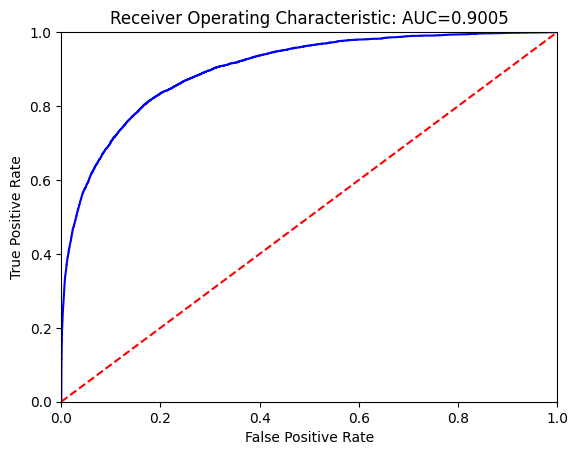

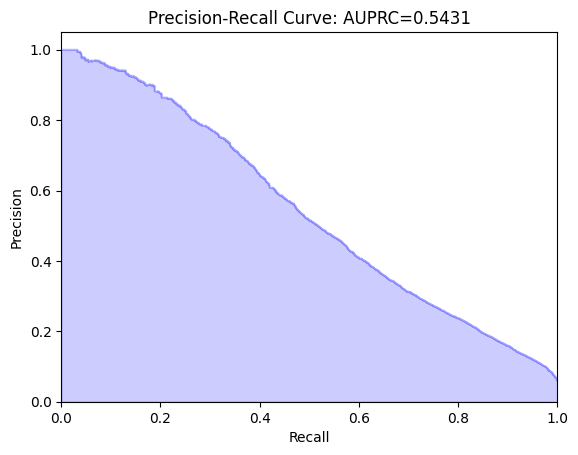

In [16]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [17]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [18]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')},
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('critical_triage_mlp')

Epoch 1/20
1764/1764 [==============================] - 16s 6ms/step - loss: 0.2779 - accuracy: 0.9432 - auc: 0.8129 - auprc: 0.2986 - true_positives: 3170.0000 - true_negatives: 329420.0000 - precision: 0.5707 - recall: 0.1522
Epoch 2/20
1764/1764 [==============================] - 10s 6ms/step - loss: 0.1592 - accuracy: 0.9486 - auc: 0.8692 - auprc: 0.4425 - true_positives: 4793.0000 - true_negatives: 329715.0000 - precision: 0.6964 - recall: 0.2302
Epoch 3/20
1764/1764 [==============================] - 9s 5ms/step - loss: 0.1553 - accuracy: 0.9491 - auc: 0.8782 - auprc: 0.4566 - true_positives: 5032.0000 - true_negatives: 329634.0000 - precision: 0.6986 - recall: 0.2417
Epoch 4/20
1764/1764 [==============================] - 10s 6ms/step - loss: 0.1515 - accuracy: 0.9499 - auc: 0.8850 - auprc: 0.4731 - true_positives: 5232.0000 - true_negatives: 329735.0000 - precision: 0.7165 - recall: 0.2513
Epoch 5/20
1764/1764 [==============================] - 10s 6ms/step - loss: 0.1499 - acc

MLP:
2755/2755 [==============================] - 6s 2ms/step
AUC: 0.9029064054674143
AUPRC: 0.5390767010665902
Sensitivity: 0.8086187429431689
Specificity: 0.8285793609598879
Score thresold: 0.07874149
2.5 97.5


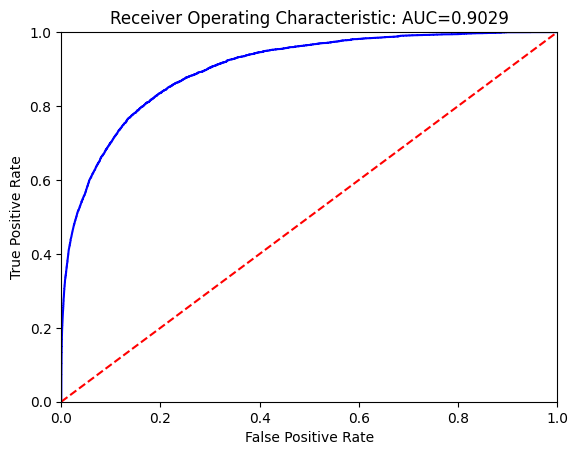

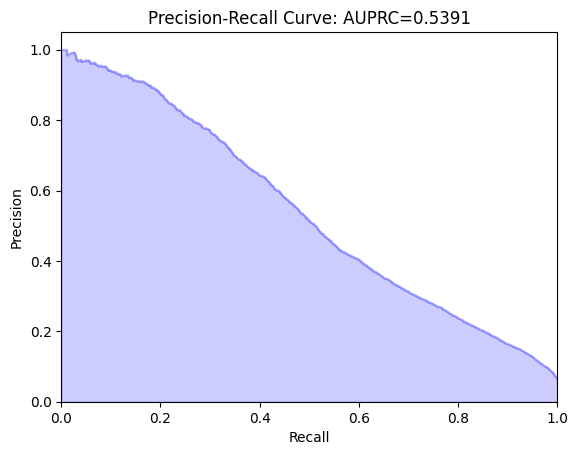

In [19]:
print("MLP:")
mlp = load_model('critical_triage_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [27]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)

score_NEWS
AUC: 0.6370474205187568
AUPRC: 0.16191181454987127
Sensitivity: 0.4685735792246895
Specificity: 0.7938510193981386
Score thresold: 2
2.5 97.5


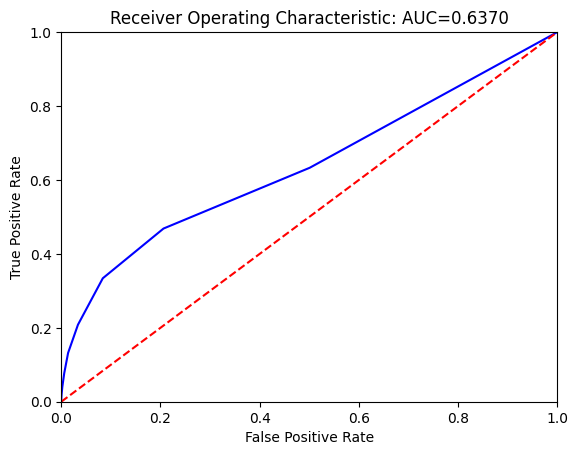

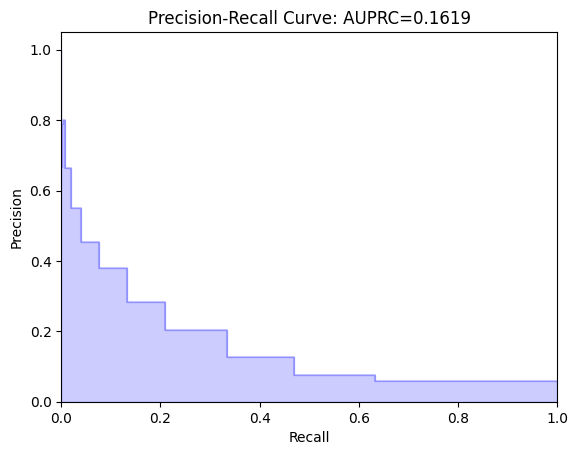

In [28]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.6220120570695026
AUPRC: 0.1466079878850494
Sensitivity: 0.41889348889725253
Specificity: 0.8218678705503181
Score thresold: 2
2.5 97.5


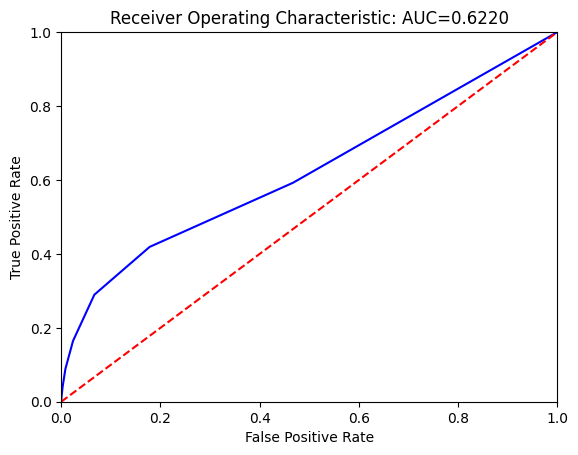

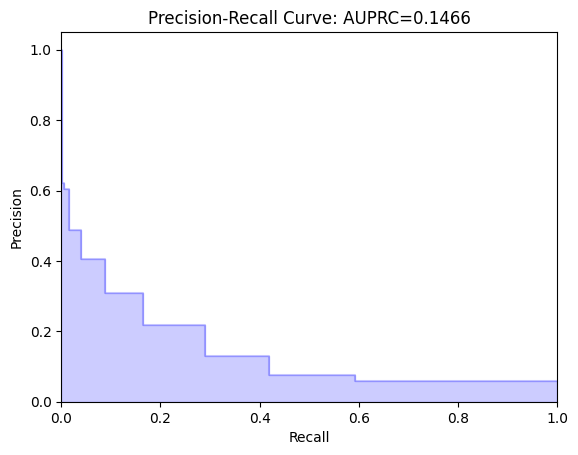

In [29]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.6885579613070328
AUPRC: 0.11142118198198758
Sensitivity: 0.6827248776815957
Specificity: 0.6131960455319098
Score thresold: 5
2.5 97.5


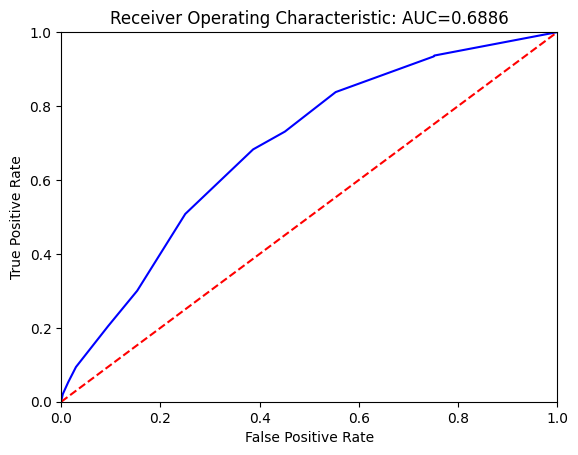

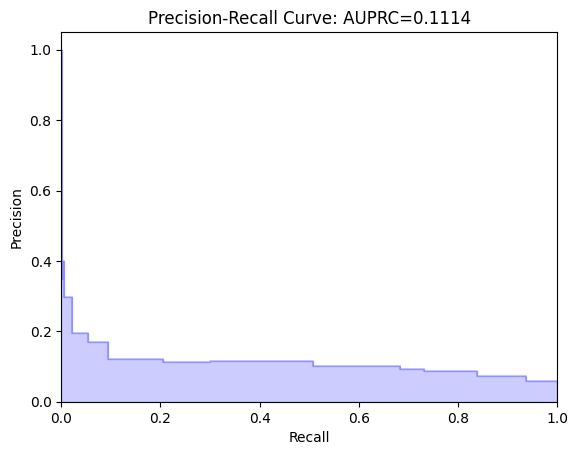

In [30]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.6202693350724213
AUPRC: 0.11688226125695778
Sensitivity: 0.44373353406097105
Specificity: 0.7714592663230448
Score thresold: 2
2.5 97.5


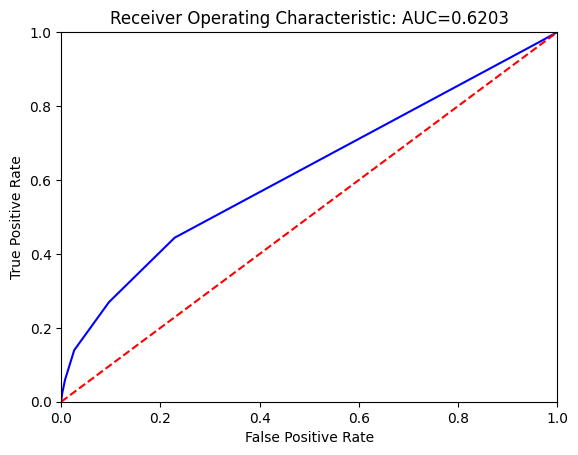

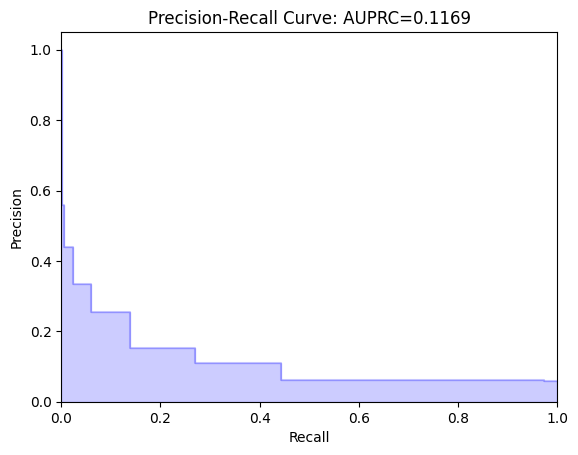

In [31]:
get_score_performance("score_MEWS", random_seed=random_seed)

### 4. Performance output

In [32]:
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold',
                                               'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap',
                                               'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity',
                                               'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_critical_triage.csv'), index=False)

result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task2.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.062,0.883 (0.88-0.885),0.438 (0.427-0.448),0.807 (0.793-0.825),0.795 (0.779-0.812),7.929
1,RF,0.080,0.893 (0.89-0.895),0.519 (0.51-0.527),0.8 (0.793-0.808),0.825 (0.822-0.827),84.809
2,GB,0.063,0.901 (0.898-0.903),0.543 (0.534-0.551),0.814 (0.804-0.826),0.823 (0.812-0.832),89.859
3,MLP,0.079,0.903 (0.9-0.906),0.539 (0.527-0.548),0.809 (0.807-0.838),0.829 (0.803-0.83),203.768
4,score_NEWS,2.000,0.637 (0.629-0.644),0.162 (0.154-0.168),0.469 (0.456-0.481),0.794 (0.792-0.797),0.000
5,score_NEWS2,2.000,0.622 (0.614-0.63),0.147 (0.14-0.152),0.419 (0.407-0.432),0.822 (0.82-0.825),0.000
6,score_REMS,5.000,0.689 (0.683-0.693),0.111 (0.108-0.114),0.683 (0.676-0.693),0.613 (0.61-0.617),0.000
7,score_MEWS,2.000,0.62 (0.614-0.627),0.117 (0.112-0.122),0.444 (0.432-0.458),0.771 (0.769-0.774),0.000
8,score_NEWS,2.000,0.637 (0.629-0.644),0.162 (0.154-0.168),0.469 (0.456-0.481),0.794 (0.792-0.797),0.000
9,score_NEWS2,2.000,0.622 (0.614-0.63),0.147 (0.14-0.152),0.419 (0.407-0.432),0.822 (0.82-0.825),0.000


In [33]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_critical_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
10,n_icu_365d,0.094003
0,age,0.093344
15,triage_sbp,0.089646
12,triage_heartrate,0.084737
18,triage_acuity,0.079927
16,triage_dbp,0.076983
11,triage_temperature,0.069906
13,triage_resprate,0.048931
14,triage_o2sat,0.045772
17,triage_pain,0.036784
